#### About this project


Supervised learning techniques should be applied in this challenge to the data collected for the U.S. census to help CharityML (a fictitious charity organization) identify people most likely to donate to their cause. 

https://www.udacity.com/course/intro-to-machine-learning-nanodegree--nd229?cjevent=e31478aa937111ea81b802750a18050d


#### About this notebook


This notebook will be structured in a following manner. 

First, data exploration will be made to find correlations and the best features to build the model on. Data pre-processing will include normalizing numerical features using MinMaxScaler as well as preprocessing the non-numeric features by one-hot encoding.

Next, several algorithms will be tried out, including Logistic Regression, AdaBoost and RandomForest classifiers. Grid search with cross validation will be used to find the best hyperparameters.

Accuracy and F-Score will be the evaluation metrics to compare performance of the models. 

In [57]:
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames
import seaborn as sns

# Import supplementary visualization code visuals.py
import visuals as vs

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import accuracy_score


from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.base import clone

In [2]:
# Pretty display for notebooks
get_ipython().run_line_magic('matplotlib', 'inline')

In [3]:
# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=10))
data.groupby(['income']).count()

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K
5,37,Private,Masters,14.0,Married-civ-spouse,Exec-managerial,Wife,White,Female,0.0,0.0,40.0,United-States,<=50K
6,49,Private,9th,5.0,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0.0,0.0,16.0,Jamaica,<=50K
7,52,Self-emp-not-inc,HS-grad,9.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,45.0,United-States,>50K
8,31,Private,Masters,14.0,Never-married,Prof-specialty,Not-in-family,White,Female,14084.0,0.0,50.0,United-States,>50K
9,42,Private,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178.0,0.0,40.0,United-States,>50K


,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
income,,,,,,,,,,,,,
<=50K,34014,34014,34014,34014,34014,34014,34014,34014,34014,34014,34014,34014,34014
>50K,11208,11208,11208,11208,11208,11208,11208,11208,11208,11208,11208,11208,11208


In [4]:
# Total number of records
n_records = data.shape[0]

# Number of records where individual's income is more than $50,000
n_greater_50k = data[data['income'] == '>50K'].shape[0]

# Number of records where individual's income is at most $50,000
n_at_most_50k = data[data['income'] == '<=50K'].shape[0]

# Percentage of individuals whose income is more than $50,000
greater_percent = round((float(n_greater_50k) / n_records) * 100, 2)

# Print the results
print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {}%".format(greater_percent))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


#### Feature exploration

In [6]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
#vs.distribution(data)

# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
#vs.distribution(features_log_transformed, transformed = True)

#### Normalizing Numerical Features

In [7]:
# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))


,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


#### Implementation: Data Preprocessing

In [8]:
features_final = pd.get_dummies(features_log_minmax_transform)

income = income_raw.apply(lambda inc: 1 if inc == '>50K' else 0)

# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

103 total features after one-hot encoding.


#### Shuffle and Split Data

In [11]:
# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


#### Evaluating Model Performance

In [12]:
TP = np.sum(income) # Counting the ones as this is the naive case. Note that 'income' is the 'income_raw' data 
#encoded to numerical values done in the data preprocessing step.
FP = income.count() - TP # Specific to the naive case

TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case


accuracy = float(TP + TN) / (TP + FP + TN + FN)
recall = float(TP) / (TP + FN)
precision = float(TP) / (TP + FP)


beta = 0.5
fscore = ((1 + beta ** 2) * precision * recall) / (((beta ** 2) * precision) + recall)

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


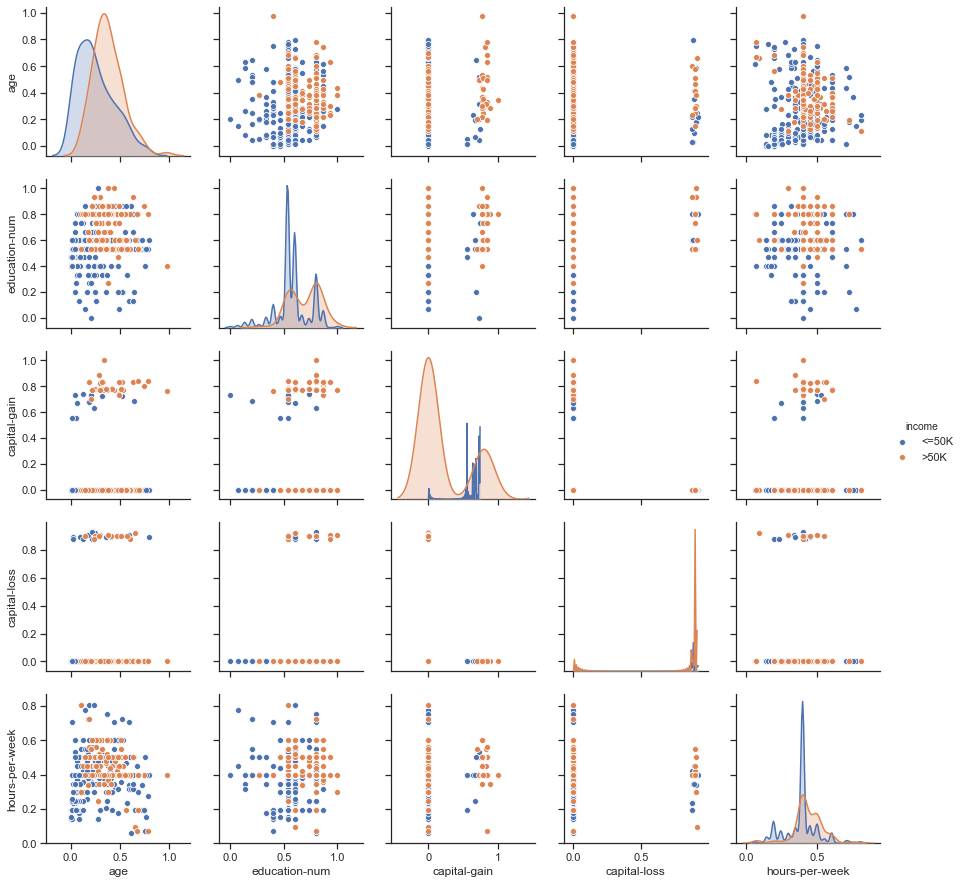

In [15]:
sns.set(style="ticks")

features_log_minmax_transform['income'] = income_raw
sns.pairplot(features_log_minmax_transform.sample(n = 500), hue="income") #plot_kws={'alpha':0.1} 

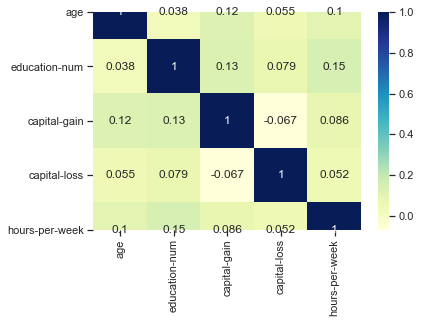

In [16]:

features_log_minmax_transform.describe()

sns.heatmap(features_log_minmax_transform.corr(), annot=True, cmap="YlGnBu")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x120898a90>,
      dtype=object)

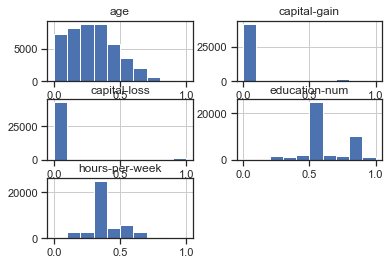

In [17]:
features_log_minmax_transform.hist()

#### Defining the predict function

In [18]:
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    

    start = time() # Get start time
    learner.fit(X_train[: sample_size], y_train[: sample_size])
    end = time() # Get end time
    

    results['train_time'] = end - start
        


    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    

    results['pred_time'] = end - start
            

    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        

    results['acc_test'] = accuracy_score(y_test, predictions_test)
    

    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta = 0.5)
        

    results['f_test'] = fbeta_score(y_test, predictions_test, beta = 0.5)
       

    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        

    return results

#### Setting up the learners

In [20]:
clf_A = RandomForestClassifier(random_state = 42)
clf_B = AdaBoostClassifier(random_state = 42)
clf_C = LogisticRegression(random_state = 42)

In [21]:
samples_100 = len(y_train)
samples_10 = int(samples_100 / 10)
samples_1 = int(samples_100 / 100)

In [ ]:
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = train_predict(clf, samples, X_train, y_train, X_test, y_test)

In [24]:
# vs.evaluate(results, accuracy, fscore)

#### Improving the results

In [36]:
clf = LogisticRegression(random_state = 42)

In [46]:
parameters = {
    'C' : [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
    'fit_intercept' : [True, False]
}

scorer = make_scorer(fbeta_score, beta=0.5)

# 'penalty'  : ['l2', 'none'],

In [ ]:
# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(estimator = clf, param_grid=parameters, scoring= scorer)


# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

In [50]:
# Get the estimator
best_clf = grid_fit.best_estimator_
# Get the estimator
best_clf

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

In [52]:
# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

Unoptimized model
------
Accuracy score on testing data: 0.8421
F-score on testing data: 0.6837

Optimized Model
------
Final accuracy score on the testing data: 0.8420
Final F-score on the testing data: 0.6835


#### Check out a supervised learning model that has "feature_importance_"

In [54]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [55]:
# Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_ 

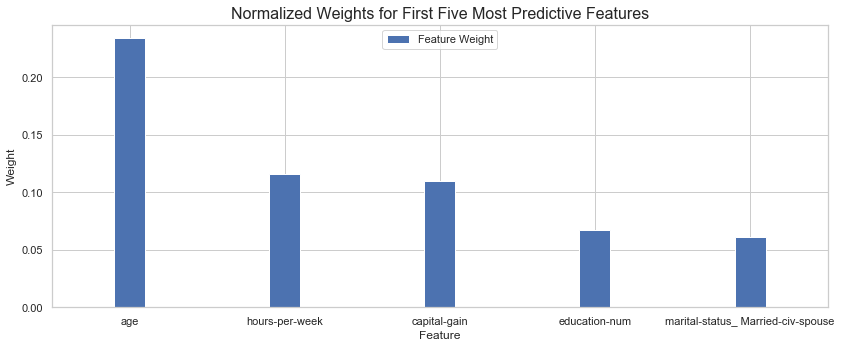

In [56]:
# Plot
vs.feature_plot(importances, X_train, y_train)

#### Extracting Feature Importance

In [58]:
# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

In [59]:
# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

In [ ]:
# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))